# 1. Simple graph

# Define a TOTAL Hamiltonian: H_p

First, given a series of Hamiltonian H1, H2, H3, a TOTAL H is defined as

H = c1 * H1 + c2 * H2 + c3 * H3

if H1, H2, H3 are all Pauli operators, then H is

In [27]:
import pennylane as qml

H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)


  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


# Define a circuit based on H_p

Here, pennylane allows convert from Hamiltonian to qubit operator directly, using Trotter-Suzuki decomposition.
The resulting circuit is a time evolution operator U(H) with the Trotter-Suzuki decomposition, and contains only pauli gates.
here choose n=2

n=1

In [28]:

# First define a device with 2 qubits
wires = 2
dev = qml.device(name='default.qubit', wires=wires)

# Define the time evolution operator U(H) with the Trotter-Suzuki decomposition
t = 1 # parameter t in the time evolution operator
n = 2 # choose n = 2, larger n gives better approximation

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(hamiltonian=H, time=t, n=n)
    return [qml.expval(qml.PauliZ(i)) for i in range(wires)]    # get expectation values of PauliZ for each qubit

print(qml.draw(qnode=circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


n=2

In [3]:

# First define a device with 2 qubits
wires = 2
dev = qml.device(name='default.qubit', wires=wires)

# Define the time evolution operator U(H) with the Trotter-Suzuki decomposition
t = 1 # parameter t in the time evolution operator
n = 2 # choose n = 2, larger n gives better approximation

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(hamiltonian=H, time=t, n=n)
    return [qml.expval(qml.PauliZ(i)) for i in range(wires)]    # get expectation values of PauliZ for each qubit

print(qml.draw(qnode=circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


In [4]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


In [5]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


# Define a graph which is a direct mapping of an image

In [6]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

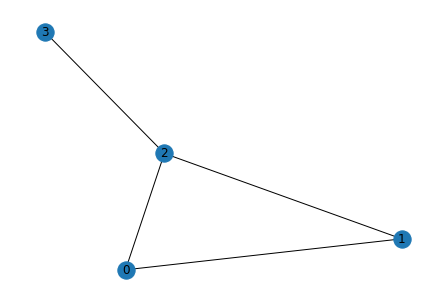

In [7]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

# Define a Hamiltonian H_p based on the graph and given task

In [29]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

TypeError: maxcut() got an unexpected keyword argument 'constrained'

# Define a circuit based on H_p

In [9]:
def qaoa_layer(gamma, alpha):
    """
    Building blocks of the QAOA ansatz.
    :param gamma: variational parameter for cost layer
    :param alpha: variational parameter for mixer layer
    :return:
    """
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [10]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [13]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

print(qml.draw(cost_function)(0.5))

TypeError: cost_function() missing 1 required positional argument: 'params'

In [18]:
print(qml.draw(qnode=circuit(params), expansion_strategy='device')())

AttributeError: 'NoneType' object has no attribute 'expansion_strategy'

In [12]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [14]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)


Optimal Parameters
[[0.59806352 0.94198485]
 [0.52797281 0.85552845]]


In [15]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


In [20]:
print(qml.draw(qnode=probs, expansion_strategy='device')())

AttributeError: 'tensor' object has no attribute 'construct'

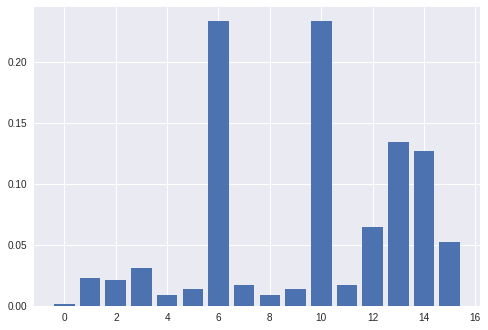

In [16]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

# 2. LOGISMOS

LOGISMOS graph: simple, no geometric constraints

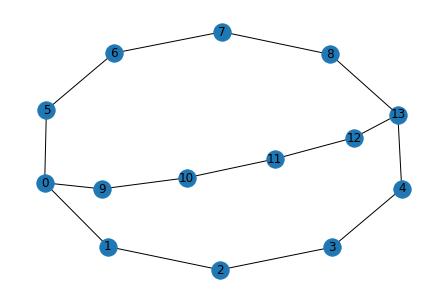

In [22]:
edges_logismos_1 = [
    (0,1), (0,5), (0,9),
    (1,2),
    (2,3),
    (3,4),
    (4,13),
    (5,6),
    (6,7),
    (7,8),
    (8,13),
    (9,10),
    (10,11),
    (11,12),
    (12,13),
]

graph_logismos = nx.Graph(edges_logismos_1)

nx.draw(graph_logismos, with_labels=True)
plt.show()


Directed LOGISMOS graph: simple, no geometric constraints

In [1]:
G_logismos = nx.DiGraph()
G_logismos.add_edge('0', '1', capacity=100.0)
G_logismos.add_edge('0', '5', capacity=100.0)
G_logismos.add_edge('0', '9', capacity=100.0)

G_logismos.add_edge('1', '2', capacity=2.0)
G_logismos.add_edge('2', '3', capacity=1.0)
G_logismos.add_edge('3', '4', capacity=1.0)
G_logismos.add_edge('4', '13', capacity=100.0)            # sink
G_logismos.add_edge('5', '6', capacity=2.0)
G_logismos.add_edge('6', '7', capacity=2.0)
G_logismos.add_edge('7', '8', capacity=1.0)
G_logismos.add_edge('8', '13', capacity=100.0)        # sink
G_logismos.add_edge('9', '10', capacity=2.0)
G_logismos.add_edge('10', '11', capacity=2.0)
G_logismos.add_edge('11', '12', capacity=1.0)
G_logismos.add_edge('12', '13', capacity=100.0)           # sink

nx.draw(G_logismos, with_labels=True)

NameError: name 'nx' is not defined

In [61]:
flow_value, flow_dict = nx.maximum_flow(G_logismos, "0", "13")
flow_value

3.0

In [62]:
cut_value, partition = nx.minimum_cut(G_logismos, "0", "13")
reachable, non_reachable = partition


In [63]:
cutset = set()
for u, nbrs in ((n, G_logismos[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('11', '12'), ('3', '4'), ('7', '8')]


# Solved min-cut graph

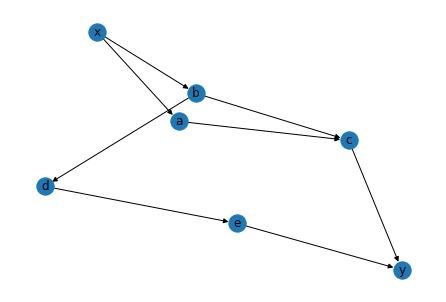

In [37]:
G = nx.DiGraph()
G.add_edge("x", "a", capacity=3.0)
G.add_edge("x", "b", capacity=1.0)
G.add_edge("a", "c", capacity=3.0)
G.add_edge("b", "c", capacity=5.0)
G.add_edge("b", "d", capacity=4.0)
G.add_edge("d", "e", capacity=2.0)
G.add_edge("c", "y", capacity=2.0)
G.add_edge("e", "y", capacity=3.0)
nx.draw(G, with_labels=True)

In [19]:
flow_value, flow_dict = nx.maximum_flow(G, "x", "y")
flow_value

3.0

In [20]:
cut_value, partition = nx.minimum_cut(G, "x", "y")
reachable, non_reachable = partition


In [21]:
cutset = set()
for u, nbrs in ((n, G[n]) for n in reachable):
    cutset.update((u, v) for v in nbrs if v in non_reachable)
print(sorted(cutset))

[('c', 'y'), ('x', 'b')]
